## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- The models use a 7 day lookback window to produce series data for training and testing
- 2 optimizations were used and an overall R2 score of .90 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-10-08 10:38:08.598968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-08T00:00:00.0000000Z', 'time_period_end': '2023-10-09T00:00:00.0000000Z', 'time_open': '2023-10-08T00:00:22.3190000Z', 'time_close': '2023-10-08T14:37:02.2530000Z', 'price_open': 1634.6, 'price_high': 1642.7, 'price_low': 1617.9, 'price_close': 1633.3, 'volume_traded': 506.6534359, 'trades_count': 1490}, {'time_period_start': '2023-10-07T00:00:00.0000000Z', 'time_period_end': '2023-10-08T00:00:00.0000000Z', 'time_open': '2023-10-07T00:00:17.1640000Z', 'time_close': '2023-10-07T23:59:58.5590000Z', 'price_open': 1646.4, 'price_high': 1648.7, 'price_low': 1631.2, 'price_close': 1635, 'volume_traded': 668.94419905, 'trades_count': 2988}, {'time_period_start': '2023-10-06T00:00:00.0000000Z', 'time_period_end': '2023-10-07T00:00:00.0000000Z', 'time_open': '2023-10-06T00:00:14.9610000Z', 'time_close': '2023-10-06T23:59:13.6470000Z', 'price_open': 1612.6, 'price_high': 1661.7, 'price_low': 1612.5, 'price_close': 1646, 'volume_traded': 2219.52488758, 'trades_coun

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-08T00:00:00.0000000Z,2023-10-09T00:00:00.0000000Z,2023-10-08T00:00:22.3190000Z,2023-10-08T14:37:02.2530000Z,1634.6,1642.7,1617.9,1633.3,506.653436,1490
1,2023-10-07T00:00:00.0000000Z,2023-10-08T00:00:00.0000000Z,2023-10-07T00:00:17.1640000Z,2023-10-07T23:59:58.5590000Z,1646.4,1648.7,1631.2,1635.0,668.944199,2988
2,2023-10-06T00:00:00.0000000Z,2023-10-07T00:00:00.0000000Z,2023-10-06T00:00:14.9610000Z,2023-10-06T23:59:13.6470000Z,1612.6,1661.7,1612.5,1646.0,2219.524888,4242
3,2023-10-05T00:00:00.0000000Z,2023-10-06T00:00:00.0000000Z,2023-10-05T00:00:09.5510000Z,2023-10-05T23:59:56.1680000Z,1647.1,1654.9,1607.7,1611.4,3279.196467,4131
4,2023-10-04T00:00:00.0000000Z,2023-10-05T00:00:00.0000000Z,2023-10-04T00:00:22.6480000Z,2023-10-04T23:59:57.3380000Z,1657.2,1658.0,1625.0,1647.0,3171.456881,3714


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


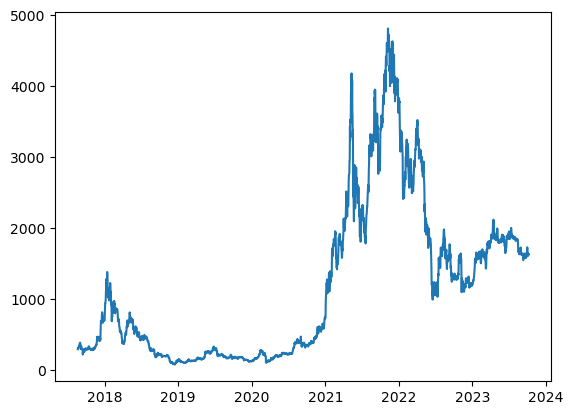

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features series
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2224, 7), (2224,), (2224,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1779, 7), (1779,), (222, 7), (222,), (223, 7), (223,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-08 10:38:36.632015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 24s 99ms/step - loss: 11.7405 - mean_absolute_error: 2.7070 - val_loss: 1.7408 - val_mean_absolute_error: 1.3129
Epoch 2/100
56/56 [==============================] - 1s 20ms/step - loss: 1.0709 - mean_absolute_error: 0.8896 - val_loss: 0.7279 - val_mean_absolute_error: 0.8454
Epoch 3/100
56/56 [==============================] - 1s 21ms/step - loss: 0.4234 - mean_absolute_error: 0.5227 - val_loss: 0.0036 - val_mean_absolute_error: 0.0451
Epoch 4/100
56/56 [==============================] - 1s 20ms/step - loss: 0.0095 - mean_absolute_error: 0.0738 - val_loss: 0.0044 - val_mean_absolute_error: 0.0511
Epoch 5/100
56/56 [==============================] - 1s 22ms/step - loss: 0.0070 - mean_absolute_error: 0.0637 - val_loss: 0.0052 - val_mean_absolute_error: 0.0555
Epoch 6/100
56/56 [==============================] - 1s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0617 - val_loss: 0.0056 - val_mean_absolute_error: 0.0588
Epoch 7/100
56

Epoch 51/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_absolute_error: 0.0499 - val_loss: 0.0045 - val_mean_absolute_error: 0.0559
Epoch 52/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0481 - val_loss: 0.0023 - val_mean_absolute_error: 0.0324
Epoch 53/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_absolute_error: 0.0463 - val_loss: 0.0024 - val_mean_absolute_error: 0.0345
Epoch 54/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_absolute_error: 0.0465 - val_loss: 0.0023 - val_mean_absolute_error: 0.0320
Epoch 55/100
56/56 [==============================] - 1s 19ms/step - loss: 0.0042 - mean_absolute_error: 0.0480 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318
Epoch 56/100
56/56 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_absolute_error: 0.0487 - val_loss: 0.0029 - val_mean_absolute_error: 0.0384
Epoch 57/1

56/56 [==============================] - 4s 6ms/step


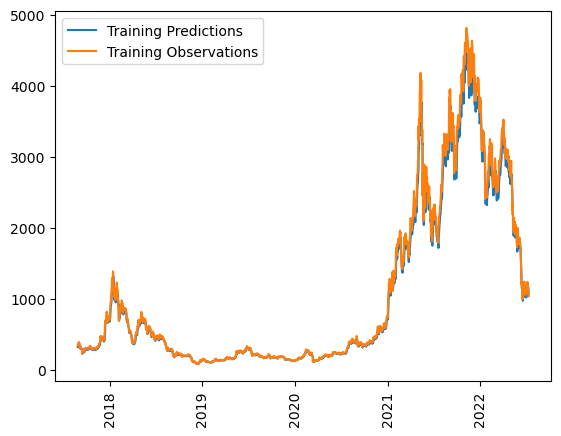

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0038935765624046326
Val MAE: 0.0526464581489563


7/7 [==============================] - 0s 5ms/step


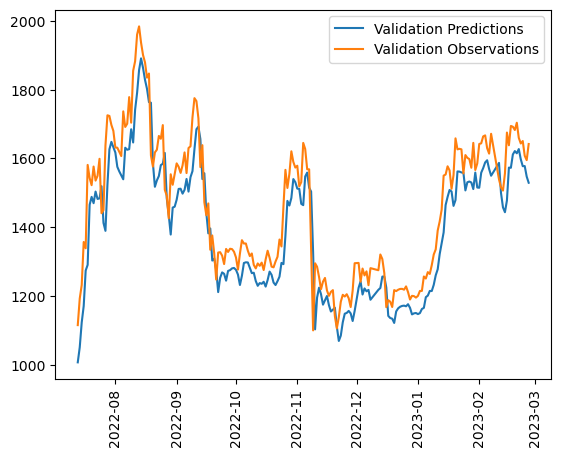

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.002524060197174549
Test MAE: 0.04585820436477661


7/7 [==============================] - 0s 4ms/step


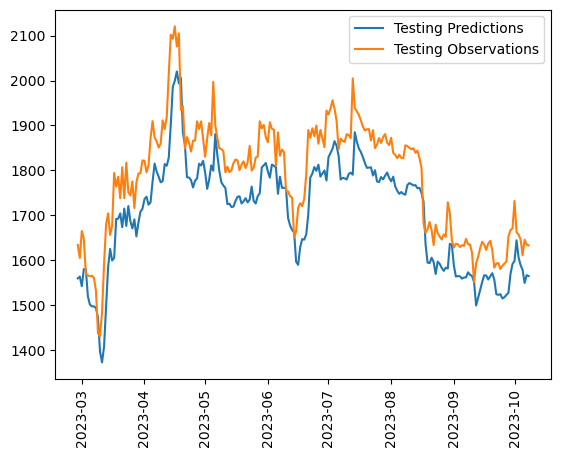

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.5193199784482306


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((867,), (867, 7), (867,), (133,), (133, 7), (133,), (112,), (112, 7), (112,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
28/28 [==============================] - 25s 194ms/step - loss: 48.9315 - mean_absolute_error: 6.9632 - val_loss: 44.1597 - val_mean_absolute_error: 6.6448
Epoch 2/200
28/28 [==============================] - 1s 22ms/step - loss: 40.9143 - mean_absolute_error: 6.3635 - val_loss: 36.2190 - val_mean_absolute_error: 6.0178
Epoch 3/200
28/28 [==============================] - 1s 19ms/step - loss: 32.8052 - mean_absolute_error: 5.6915 - val_loss: 27.9116 - val_mean_absolute_error: 5.2826
Epoch 4/200
28/28 [==============================] - 0s 17ms/step - loss: 24.3750 - mean_absolute_error: 4.8948 - val_loss: 19.4071 - val_mean_absolute_error: 4.4048
Epoch 5/200
28/28 [==============================] - 1s 22ms/step - loss: 16.0450 - mean_absolute_error: 3.9521 - val_loss: 11.4815 - val_mean_absolute_error: 3.3877
Epoch 6/200
28/28 [==============================] - 1s 19ms/step - loss: 8.8182 - mean_absolute_error: 2.8929 - val_loss: 5.2792 - val_mean_absolute_error: 2.2965
Epoc

28/28 [==============================] - 1s 24ms/step - loss: 0.0060 - mean_absolute_error: 0.0603 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 51/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0053 - mean_absolute_error: 0.0555 - val_loss: 0.0012 - val_mean_absolute_error: 0.0264
Epoch 52/200
28/28 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_absolute_error: 0.0549 - val_loss: 0.0012 - val_mean_absolute_error: 0.0266
Epoch 53/200
28/28 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_absolute_error: 0.0539 - val_loss: 0.0024 - val_mean_absolute_error: 0.0418
Epoch 54/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0051 - mean_absolute_error: 0.0539 - val_loss: 0.0029 - val_mean_absolute_error: 0.0463
Epoch 55/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0012 - val_mean_absolute_error: 0.0262
Epoch 56/200
28/28 [===

Epoch 100/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 101/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0046 - mean_absolute_error: 0.0504 - val_loss: 0.0014 - val_mean_absolute_error: 0.0287
Epoch 102/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0046 - mean_absolute_error: 0.0510 - val_loss: 0.0029 - val_mean_absolute_error: 0.0463
Epoch 103/200
28/28 [==============================] - 1s 25ms/step - loss: 0.0048 - mean_absolute_error: 0.0519 - val_loss: 0.0012 - val_mean_absolute_error: 0.0260
Epoch 104/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0048 - mean_absolute_error: 0.0514 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 105/200
28/28 [==============================] - 1s 20ms/step - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0014 - val_mean_absolute_error: 0.0290
Epoc

28/28 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0484 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 150/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0045 - mean_absolute_error: 0.0499 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301
Epoch 151/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301
Epoch 152/200
28/28 [==============================] - 1s 23ms/step - loss: 0.0048 - mean_absolute_error: 0.0526 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 153/200
28/28 [==============================] - 1s 20ms/step - loss: 0.0043 - mean_absolute_error: 0.0490 - val_loss: 0.0014 - val_mean_absolute_error: 0.0287
Epoch 154/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0496 - val_loss: 0.0011 - val_mean_absolute_error: 0.0253
Epoch 155/200
28/2

28/28 [==============================] - 1s 22ms/step - loss: 0.0040 - mean_absolute_error: 0.0470 - val_loss: 0.0027 - val_mean_absolute_error: 0.0452
Epoch 199/200
28/28 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 0.0013 - val_mean_absolute_error: 0.0275
Epoch 200/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0041 - mean_absolute_error: 0.0478 - val_loss: 0.0015 - val_mean_absolute_error: 0.0298


28/28 [==============================] - 3s 5ms/step


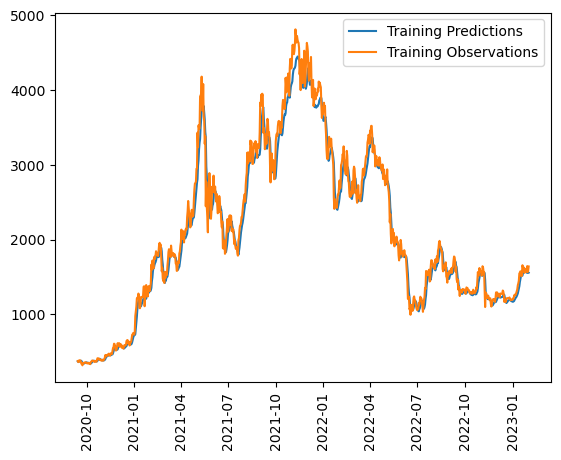

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0014832589076831937
Val MAE: 0.029750831425189972


5/5 [==============================] - 0s 22ms/step


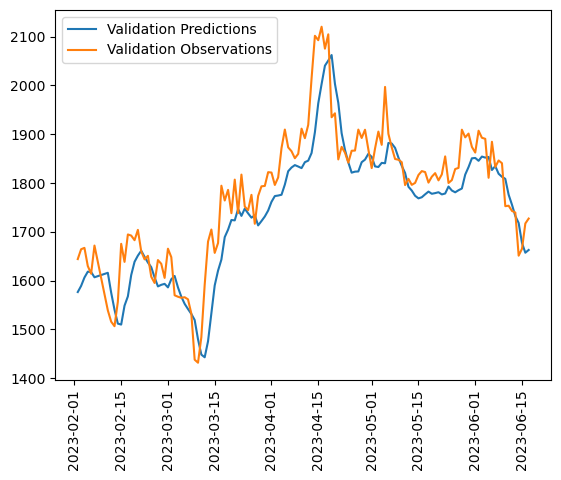

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0008231152896769345
Test MAE: 0.02258477546274662


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 13ms/step
R2 Score:  0.8305021772350141


4/4 [==============================] - 0s 56ms/step


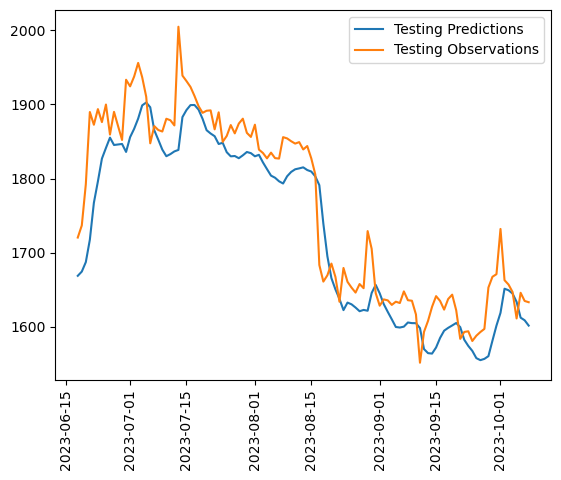

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [42]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 15s 95ms/step - loss: 8.0101 - mean_absolute_error: 2.0943 - val_loss: 0.6629 - val_mean_absolute_error: 0.8108
Epoch 2/300
28/28 [==============================] - 0s 13ms/step - loss: 0.5523 - mean_absolute_error: 0.5930 - val_loss: 0.0526 - val_mean_absolute_error: 0.2178
Epoch 3/300
28/28 [==============================] - 0s 13ms/step - loss: 0.3614 - mean_absolute_error: 0.4709 - val_loss: 0.0230 - val_mean_absolute_error: 0.1371
Epoch 4/300
28/28 [==============================] - 1s 21ms/step - loss: 0.3501 - mean_absolute_error: 0.4697 - val_loss: 0.0235 - val_mean_absolute_error: 0.1404
Epoch 5/300
28/28 [==============================] - 0s 16ms/step - loss: 0.2773 - mean_absolute_error: 0.4147 - val_loss: 0.0108 - val_mean_absolute_error: 0.0929
Epoch 6/300
28/28 [==============================] - 1s 19ms/step - loss: 0.0844 - mean_absolute_error: 0.2292 - val_loss: 0.0694 - val_mean_absolute_error: 0.2612
Epoch 7/300
28/

Epoch 51/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0076 - mean_absolute_error: 0.0703 - val_loss: 0.0133 - val_mean_absolute_error: 0.1115
Epoch 52/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0165 - mean_absolute_error: 0.1057 - val_loss: 0.0435 - val_mean_absolute_error: 0.2064
Epoch 53/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0115 - mean_absolute_error: 0.0835 - val_loss: 0.1139 - val_mean_absolute_error: 0.3363
Epoch 54/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0241 - mean_absolute_error: 0.1244 - val_loss: 0.0194 - val_mean_absolute_error: 0.1364
Epoch 55/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0100 - mean_absolute_error: 0.0820 - val_loss: 9.1497e-04 - val_mean_absolute_error: 0.0223
Epoch 56/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0088 - mean_absolute_error: 0.0763 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281
Epoch 

28/28 [==============================] - 1s 23ms/step - loss: 0.0066 - mean_absolute_error: 0.0645 - val_loss: 0.0099 - val_mean_absolute_error: 0.0956
Epoch 101/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0063 - mean_absolute_error: 0.0639 - val_loss: 0.0141 - val_mean_absolute_error: 0.1158
Epoch 102/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0094 - mean_absolute_error: 0.0810 - val_loss: 0.0332 - val_mean_absolute_error: 0.1803
Epoch 103/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0254 - mean_absolute_error: 0.1373 - val_loss: 0.0402 - val_mean_absolute_error: 0.1987
Epoch 104/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0175 - mean_absolute_error: 0.1121 - val_loss: 0.0326 - val_mean_absolute_error: 0.1783
Epoch 105/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0093 - mean_absolute_error: 0.0804 - val_loss: 9.9163e-04 - val_mean_absolute_error: 0.0253
Epoch 106/300


28/28 [==============================] - 1s 24ms/step - loss: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 9.3389e-04 - val_mean_absolute_error: 0.0243
Epoch 150/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0060 - mean_absolute_error: 0.0620 - val_loss: 0.0117 - val_mean_absolute_error: 0.1046
Epoch 151/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0104 - mean_absolute_error: 0.0843 - val_loss: 0.0102 - val_mean_absolute_error: 0.0976
Epoch 152/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0075 - mean_absolute_error: 0.0682 - val_loss: 0.0027 - val_mean_absolute_error: 0.0465
Epoch 153/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0060 - mean_absolute_error: 0.0583 - val_loss: 0.0025 - val_mean_absolute_error: 0.0437
Epoch 154/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0131 - mean_absolute_error: 0.0915 - val_loss: 9.0906e-04 - val_mean_absolute_error: 0.0228
Epoch 155/

28/28 [==============================] - 0s 14ms/step - loss: 0.0120 - mean_absolute_error: 0.0915 - val_loss: 0.0558 - val_mean_absolute_error: 0.2348
Epoch 199/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0228 - mean_absolute_error: 0.1267 - val_loss: 0.0175 - val_mean_absolute_error: 0.1298
Epoch 200/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0196 - mean_absolute_error: 0.1184 - val_loss: 7.3195e-04 - val_mean_absolute_error: 0.0202
Epoch 201/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0077 - val_mean_absolute_error: 0.0838
Epoch 202/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0064 - mean_absolute_error: 0.0632 - val_loss: 0.0057 - val_mean_absolute_error: 0.0712
Epoch 203/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0051 - mean_absolute_error: 0.0577 - val_loss: 7.2427e-04 - val_mean_absolute_error: 0.0194
Epoch 204/

28/28 [==============================] - 0s 16ms/step - loss: 0.0082 - mean_absolute_error: 0.0756 - val_loss: 0.0293 - val_mean_absolute_error: 0.1691
Epoch 248/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0145 - mean_absolute_error: 0.1008 - val_loss: 0.0055 - val_mean_absolute_error: 0.0690
Epoch 249/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0600 - val_loss: 7.1364e-04 - val_mean_absolute_error: 0.0194
Epoch 250/300
28/28 [==============================] - 1s 19ms/step - loss: 0.0091 - mean_absolute_error: 0.0775 - val_loss: 0.0045 - val_mean_absolute_error: 0.0618
Epoch 251/300
28/28 [==============================] - 0s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0022 - val_mean_absolute_error: 0.0410
Epoch 252/300
28/28 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_absolute_error: 0.0427 - val_loss: 0.0016 - val_mean_absolute_error: 0.0340
Epoch 253/300


28/28 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_absolute_error: 0.0655 - val_loss: 0.0040 - val_mean_absolute_error: 0.0580
Epoch 297/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_absolute_error: 0.0639 - val_loss: 9.1754e-04 - val_mean_absolute_error: 0.0240
Epoch 298/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0015 - val_mean_absolute_error: 0.0328
Epoch 299/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0062 - mean_absolute_error: 0.0615 - val_loss: 0.0194 - val_mean_absolute_error: 0.1368
Epoch 300/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_absolute_error: 0.0781 - val_loss: 0.0024 - val_mean_absolute_error: 0.0426


28/28 [==============================] - 2s 4ms/step


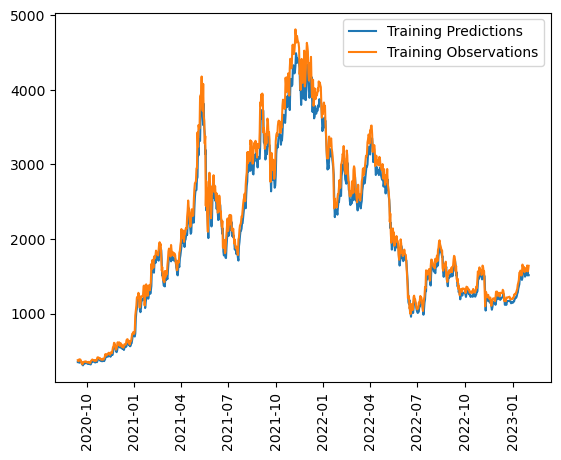

In [43]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [44]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.002354714320972562
Val MAE: 0.04259920492768288


5/5 [==============================] - 0s 8ms/step


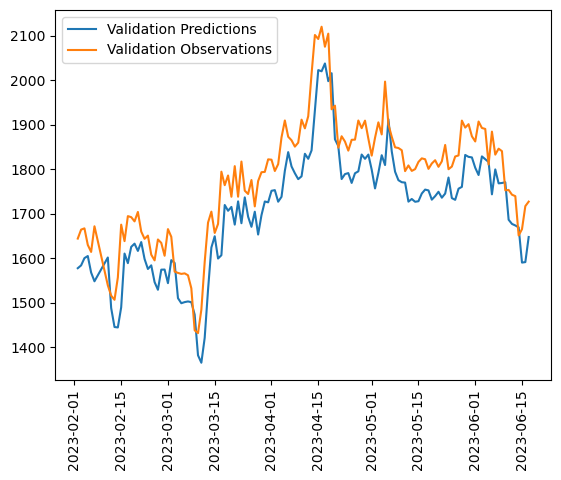

In [45]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [46]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0018843587022274733
Test MAE: 0.04003594070672989


4/4 [==============================] - 0s 24ms/step


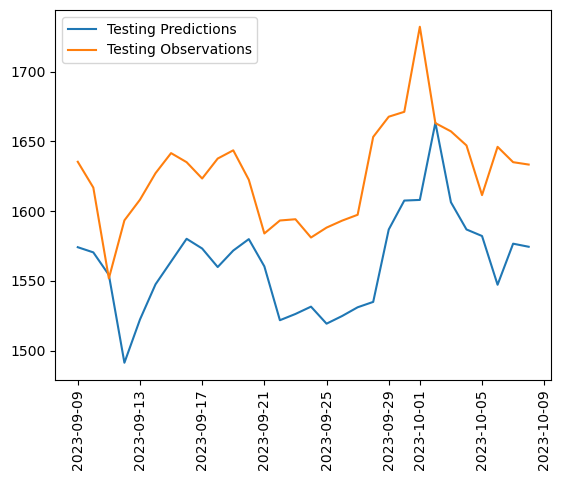

In [47]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [48]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.6119679070211441


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the best scoring model for testing predictions

In [49]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7
#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

#Adding future dates at the end of the dateset   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 103ms/step
[7.3616138, 7.3532434, 7.356367, 7.356915, 7.3578267, 7.358014, 7.3576837]
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-14
2023-10-15


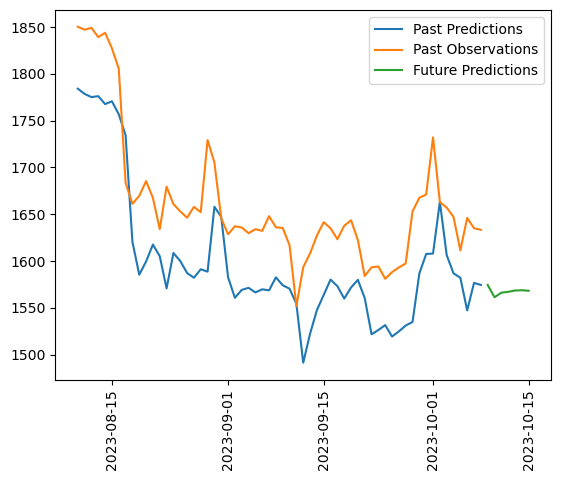

In [50]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [51]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [52]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [53]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [54]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-11,1878.7,1792.377441,1833.005859,1806.920288
2023-07-12,1871.7,1795.028809,1836.670044,1806.732422
2023-07-13,2004.8,1790.505005,1838.662720,1798.805786
2023-07-14,1938.9,1884.963379,1882.928711,1919.358521
2023-07-15,1931.5,1864.215820,1892.432007,1876.875244
...,...,...,...,...
2023-10-04,1647.0,1589.503052,1644.948975,1586.775269
2023-10-05,1611.4,1578.722534,1633.764282,1582.084351
2023-10-06,1646.0,1549.838867,1612.486816,1547.145996


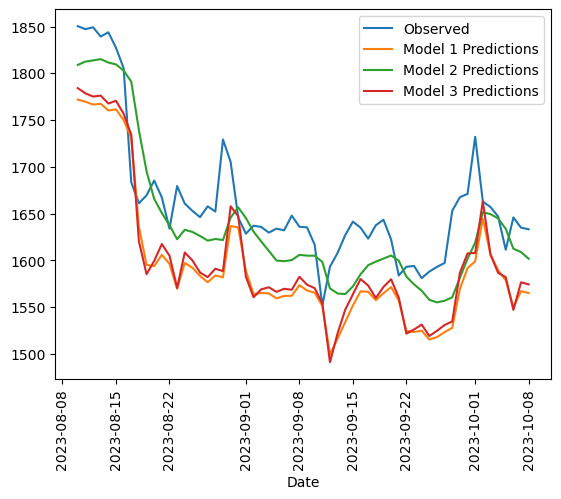

In [55]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [56]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [57]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')

In [58]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.5193199784482306
Model 2 R2 Score:  0.8305021772350141
Model 3 R2 Score:  0.6119679070211441
